#  **Testing Gaussian EP on a given RBM**


In [123]:
using Pkg
using Plots
#using Revise
using DelimitedFiles


In [124]:
include("../src/GaussianEP.jl")
include("../Sampling/Sampling.jl")
#Pkg.activate("/Users/luca/repos/GaussianEP/")
#using GaussianEP

Main.Sampling

In [125]:
# Number of visible and hidden units, Gaussian weigths
N = 12
M = 4
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];

# (Pv, Ph) = (Gaussian - Gaussian) priors

In [126]:
μv = 3.0; βv = 5.0;
μh = 5.0; βh = 4.0;

Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [GaussianEP.GaussianPrior(μh, βh, 0.0) for i = 1:M];
P0 = vcat(Pv,Ph);

In [127]:
out = GaussianEP.expectation_propagation(H, P0, nprint = 100);

it: 100 Δav: 0.0002764134581045852
it: 154 Δav: 9.347994875952281e-7


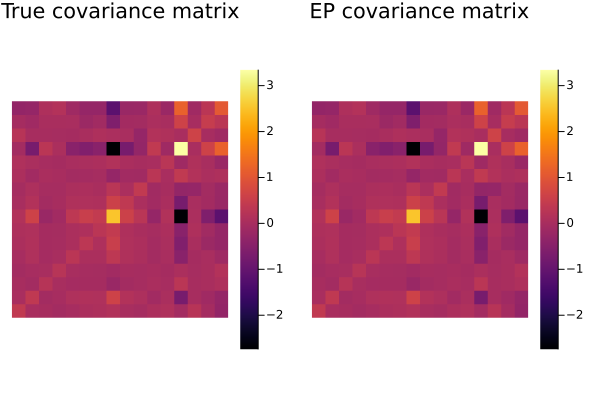

In [128]:
using Plots

Σan = GaussianEP.compute_analytic(w,Pv,Ph)
p1 = heatmap(Σan, aspect_ratio=1, ticks= :false, showaxis = :false, title="True covariance matrix", titlelocation=:center)
p2 = heatmap(out.state.Σ, aspect_ratio=1, ticks= :false, showaxis =:false, title="EP covariance matrix", titlelocation=:center)
Plots.plot(p1,p2)

# (Pv, Ph) = (Binary - Gaussian) priors

In [129]:
x0v = 0.0; x1v = 1.0; ρ = 0.9;
μh = 0.5; βh = 3.0; 

Pv = [GaussianEP.BinaryPrior(x0v, x1v, ρ) for i = 1:N]
Ph = [GaussianEP.GaussianPrior(μh, βh, 0.0) for j = 1:M]
P0 = vcat(Pv,Ph);

In [130]:
out = GaussianEP.expectation_propagation(H, P0, epsconv = 1e-7, maxiter=100000);

it: 100 Δav: 1.020941800422559e-5
it: 151 Δav: 9.542281942387376e-8


In [131]:
av_an, va_an, cov_an = GaussianEP.compute_analytic(w, Pv, Ph);

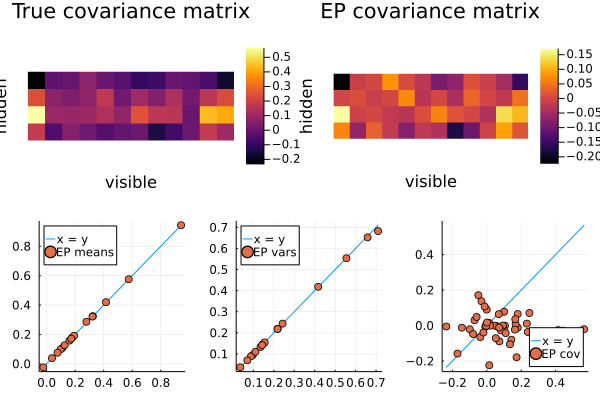

In [132]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(out.state.Σ[1:N,N+1:N+M]', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="EP covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, out.av, seriestype = :scatter, label = "EP means", legend = :topleft)
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft)
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(out.state.Σ[N+1:N+M,1:N]), seriestype = :scatter, label = "EP cov", legend = :bottomright)
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

In [133]:
Pv = [Sampling.BinaryPrior(x0v, x1v, ρ) for i = 1:N]
Ph = [Sampling.GaussianPrior(μh, βh, 0.0) for j = 1:M]
P0 = vcat(Pv,Ph);

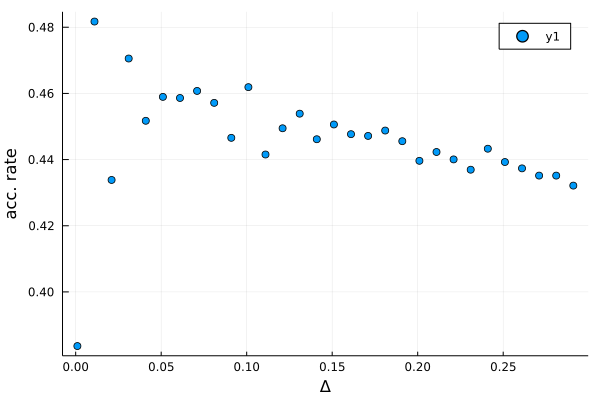

In [134]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.001:0.01:0.3)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0,10^5)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/an-na/.julia/packages/Plots/isZEW/src/args.jl:1260


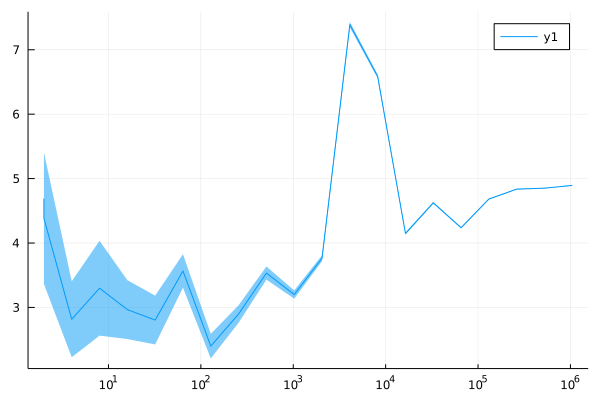

In [135]:
# Get thermalization time

Δ = 0.05
nblocks = 21
mc_energy = Sampling.MC_t_therm(nblocks, w, P0, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [136]:
# Sampling using MCMC

Nconf = 10^5
Twait = 10^6
mc_out = Sampling.MC_sim(w, P0, Twait, Δ; N_iter=Nconf);

In [137]:
# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out);

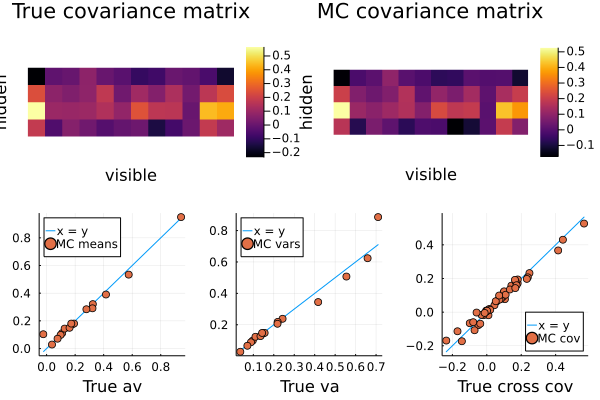

In [138]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, av_mc, seriestype = :scatter, label = "MC means", legend = :topleft, xlabel = "True av")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, va_mc, seriestype = :scatter, label = "MC vars", legend = :topleft, xlabel = "True va")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_mc), seriestype = :scatter, label = "MC cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Gaussian, ReLu) Priors

In [139]:
γ_start = 2.5
step = 0.1
γ = γ_start
N_iter = 4

μv = 3.0; βv = 5.0;
Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];
for i=1:N_iter
    Ph = [GaussianEP.ReLUPrior(γ,0.0) for j = 1:M ]
    P0 = vcat(Pv,Ph)
    if i==1
        out = GaussianEP.expectation_propagation(H, P0)
    else
        out = GaussianEP.expectation_propagation(H, P0; state = init_state)
    end
    γ -= step
    init_state = out.state
end

LoadError: [91mDomainError with Combined variance must be positive:[39m
